**Tujuan**: Memprediksi apakah sebuat teks review product memiliki sentimen positif atau negatif.
Data set yang digunakan:  Amazon product review dataset untuk produk kategori Baby (https://s3.amazonaws.com/amazon-reviews-pds/tsv/index.txt)

Algoritma yang digunakan adalah gensim dan Word2Vec.

# Preparation (Library Set Up)

In [ ]:
!pip install gensim --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade

Lalu import library yang dibutuhkan.

In [ ]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools
import gzip

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


***STOPWORDS***

Stop words adalah kata-kata yang sering dipakai namun tidak berguna dalam text processing, seperti 'yes, no, and the' dll. Library NLTK sudah menyediakan list stopwords dan dapat kita download.

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Predefine value.

In [ ]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLEANING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 2   
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

# Data Preparation and Cleansing

Data sudah langsung didownload melalui website Amazon dan berbentuk .gz, jadi harus diunzip terlebih dahulu.

In [ ]:
# Download data
!curl -O https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Baby_v1_00.tsv.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  340M  100  340M    0     0  83.1M      0  0:00:04  0:00:04 --:--:-- 83.1M


In [ ]:
# Unzip Data
!gunzip amazon_reviews_us_Baby_v1_00.tsv.gz

gzip: amazon_reviews_us_Baby_v1_00.tsv already exists; do you wish to overwrite (y or n)? y


Data yang akan digunakan masih dalam format TSV (Tab-separated values). Karena dipisahkan oleh tab, data TSV sering kali ditemukan *badlines*, yaitu memiliki jumlah kolom yang tidak konsisten. Di data kita, kebanyakan data memiliki 15 kolom, namun ada sebagian kecil data yang terbagi dalam 22 kolom. Sebelum membuat dataframe, kita akan menghapus data yang memiliki 22 kolom.

In [ ]:
df = pd.read_csv('amazon_reviews_us_Baby_v1_00.tsv', sep='\t', error_bad_lines=False)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 9553: expected 15 fields, saw 22\nSkipping line 16240: expected 15 fields, saw 22\nSkipping line 21292: expected 15 fields, saw 22\nSkipping line 43160: expected 15 fields, saw 22\n'
b'Skipping line 75057: expected 15 fields, saw 22\nSkipping line 77996: expected 15 fields, saw 22\nSkipping line 90688: expected 15 fields, saw 22\n'
b'Skipping line 149039: expected 15 fields, saw 22\nSkipping line 156530: expected 15 fields, saw 22\nSkipping line 165609: expected 15 fields, saw 22\nSkipping line 174362: expected 15 fields, saw 22\nSkipping line 191190: expected 15 fields, saw 22\n'
b'Skipping line 201182: expected 15 fields, saw 22\nSkipping line 206503: expected 15 fields, saw 22\nSkipping line 231942: expected 15 fields, saw 22\nSkippin

In [ ]:
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,9970739,R8EWA1OFT84NX,B00GSP5D94,329991347,Summer Infant SwaddleMe Adjustable Infant Wrap...,Baby,5,0.0,0.0,N,Y,Great swaddled blankets,Loved these swaddle blankets and so did my dau...,2015-08-31
1,US,23538442,R2JWY4YRQD4FOP,B00YYDDZGU,646108902,Pacifier Clip Girl (3 Pack) Ziggy Baby 2-Sided...,Baby,5,0.0,0.0,N,N,Too cute and really nice,These are adorable pacifier clips. SavvyBaby h...,2015-08-31
2,US,8273344,RL5ESX231LZ0B,B00BUBNZC8,642922361,Udder Covers - Breast Feeding Nursing Cover,Baby,5,0.0,0.0,N,Y,Five Stars,Great gift,2015-08-31
3,US,24557753,RRMS9ZWJ2KD08,B00AWLZFTS,494272733,Gerber Graduates Fun Pack Utensils,Baby,5,0.0,0.0,N,Y,Cute; wash up nicely in dishwasher.,These forks are great for my 10 month old daug...,2015-08-31
4,US,46263340,R14I3ZG5E6S7YM,B00KM60D3Q,305813185,Summer Infant Ultra Sight Pan/Scan/Zoom Video ...,Baby,5,0.0,0.0,N,Y,Love it!,I wanted something for piece of mind with my l...,2015-08-31


Dari cuplikan tabel di atas, text yang ingin kita analisis di kolom *review body*. Sedangkan kolom yang menentukan tingkat sentimen dari review adalah *star_rating*, namun kolom *star_rating* masih dalam range 1, 2, 3, 4, dan 5. 

Dalam klasifikasi ini, kita akan menggolongkan sebuah review ke dalam 2 label kategori: POSITIF (1), DAN NEGATIF(0). Terlebih dahulu kita akan mengkonversi *star_rating* ke dalam 2 kategori tersebut.

Untuk mempermudah training dan penilaian, kolom yang memiliki *star_review* = 3 akan kita eliminasikan.

In [ ]:
df = df[df['star_rating'] != 3]

In [ ]:
# Membuat kondisi untuk mengisi kolom 'label' berdasarkan kolom 'star_rating'

conditions = [
    (df['star_rating'] == 1),
    (df['star_rating'] == 2),
  #  (df['star_rating'] == 3),
    (df['star_rating'] == 4),
    (df['star_rating'] == 5)
    ]

# List of values untuk kolom label
values = [0, 0, 1, 1]
# values = [-1, -1, 0, 1, 1]

# Buat kolom 'label' lalu isi sesuai conditions dan values yang sudah ditetapkan
df['label'] = np.select(conditions, values)

# Menampilkan data frame dengan kolom 'label'
df.tail()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,label
1749143,US,52873209,R7W6TPBOZ7WJZ,B00000J0HR,865087255,Sassy Smiley Face Rattle,Baby,5,2.0,2.0,N,N,Great toy,My 6 month old son loves to play with this toy...,1999-07-14,1
1749144,US,51161415,R1Y4I7KYF7Y5MH,B00000J0HU,640300757,Sassy 836 - Fascination Station (Discontinued ...,Baby,5,0.0,0.0,N,N,a must have for active babies,Not only does my son love this toy but so do I...,1999-07-14,1
1749145,US,52165416,R35M9WTWVWMLX9,B00000ISE2,455759081,Neurosmith - Music Blocks with Mozart Music Ca...,Baby,5,27.0,27.0,N,N,"Great Music, Great Fun",This toy offers a fun learning experience and ...,1999-07-13,1
1749146,US,52784607,R2LUF1DDNNRNAJ,B00000DMCK,608283258,Lamaze Grip & Grab Rattle (Discontinued by Man...,Baby,5,18.0,18.0,N,N,The rattle that keeps up with your childs abil...,Our three-month-old had fun with this as soon ...,1999-07-13,1
1749147,US,52165046,RV7B3DO7H3GC8,B00000J0HV,919392690,Sassy Hourglass Rattle,Baby,5,2.0,2.0,N,N,"Colorful, intriguing, and exciting rattle!",The hourglass rattle by Sassy is definitely a ...,1999-07-13,1


Text(0.5, 1.0, 'Dataset labels distribuition')

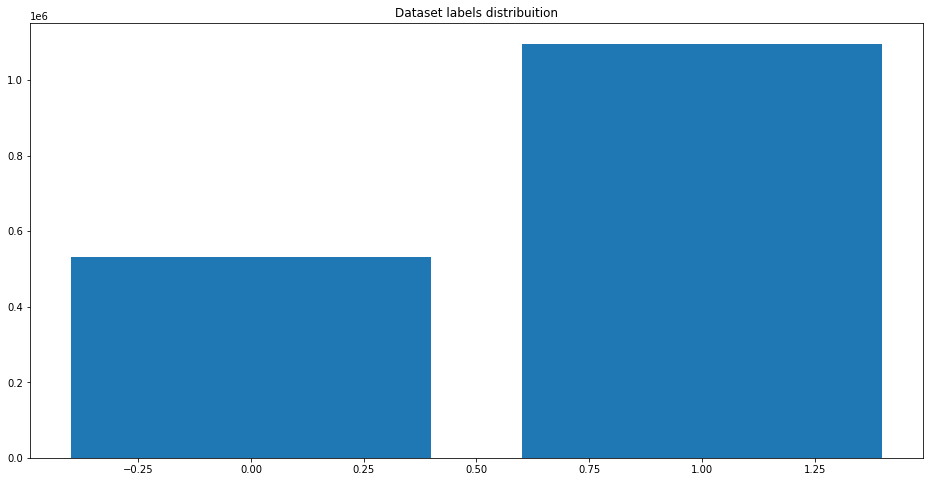

In [ ]:
label_cnt = Counter(df.label)

plt.figure(figsize=(16,8))
plt.bar(label_cnt.keys(), label_cnt.values())
plt.title("Dataset labels distribuition")

Buat data frame baru yang hanya berisikan *label* dan *review_body* saja.

In [ ]:
df2 = df[['label', 'review_body']].copy()
df2.head()

,label,review_body
0,1,Loved these swaddle blankets and so did my dau...
1,1,These are adorable pacifier clips. SavvyBaby h...
2,1,Great gift
3,1,These forks are great for my 10 month old daug...
4,1,I wanted something for piece of mind with my l...


Buat kolom baru yaitu *text* yang berisikan copy dari *review_body* untuk  kita lakukan text processing. Kolom *text* harus berupa object/string.

In [ ]:
df2['text'] = df2["review_body"].astype(str)

In [ ]:
df2.head()

,label,review_body,text
0,1,Loved these swaddle blankets and so did my dau...,Loved these swaddle blankets and so did my dau...
1,1,These are adorable pacifier clips. SavvyBaby h...,These are adorable pacifier clips. SavvyBaby h...
2,1,Great gift,Great gift
3,1,These forks are great for my 10 month old daug...,These forks are great for my 10 month old daug...
4,1,I wanted something for piece of mind with my l...,I wanted something for piece of mind with my l...


Periksa data type untuk masing-masing kolom.

In [ ]:
df2.dtypes

label           int64
review_body    object
text           object
dtype: object

# Text Processing

Sebelum masih ke training dan pembuatan model, ada beberapa tahap text processing yang harus dilalui, seperti lower-casing, words stemming (contoh, running --> run), penghapusan stop words, dan penghapusan tanda baca,




Stopwords package sudah didownload dari NLTK library.

In [ ]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [ ]:
# Penghapusan tanda baca & stop word

def preprocess(text, stem=False):
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [ ]:
# lower-casing

df2.text = df2.text.apply(lambda x: preprocess(x))

# Split Train and Test Data

In [ ]:
df_train = df2.sample(frac=0.8, random_state=0)
df_test = df2.sample(frac=0.2, random_state=0)

# Word2Vec

Word2V

In [ ]:
documents = [_text.split() for _text in df_train.text] 

In [ ]:
w2v_model = gensim.models.word2vec.Word2Vec(window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

2021-07-25 14:52:00,101 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec(vocab=0, vector_size=100, alpha=0.025)', 'datetime': '2021-07-25T14:52:00.101301', 'gensim': '4.0.1', 'python': '3.7.11 (default, Jul  3 2021, 18:01:19) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'created'}


In [ ]:
w2v_model.build_vocab(documents)

2021-07-25 14:52:03,255 : INFO : collecting all words and their counts
2021-07-25 14:52:03,259 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-07-25 14:52:03,327 : INFO : PROGRESS: at sentence #10000, processed 305845 words, keeping 14765 word types
2021-07-25 14:52:03,393 : INFO : PROGRESS: at sentence #20000, processed 620700 words, keeping 19996 word types
2021-07-25 14:52:03,457 : INFO : PROGRESS: at sentence #30000, processed 930119 words, keeping 23814 word types
2021-07-25 14:52:03,525 : INFO : PROGRESS: at sentence #40000, processed 1248154 words, keeping 27081 word types
2021-07-25 14:52:03,589 : INFO : PROGRESS: at sentence #50000, processed 1562540 words, keeping 29943 word types
2021-07-25 14:52:03,651 : INFO : PROGRESS: at sentence #60000, processed 1880225 words, keeping 32509 word types
2021-07-25 14:52:03,714 : INFO : PROGRESS: at sentence #70000, processed 2195702 words, keeping 34781 word types
2021-07-25 14:52:03,780 : INFO : PROGRESS:

In [ ]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=20)   #W2V_EPOCH

2021-07-25 14:52:41,121 : INFO : Word2Vec lifecycle event {'msg': 'training model with 8 workers on 30031 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=7', 'datetime': '2021-07-25T14:52:41.121771', 'gensim': '4.0.1', 'python': '3.7.11 (default, Jul  3 2021, 18:01:19) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'train'}
2021-07-25 14:52:42,199 : INFO : EPOCH 1 - PROGRESS: at 1.73% examples, 605304 words/s, in_qsize 12, out_qsize 3
2021-07-25 14:52:43,216 : INFO : EPOCH 1 - PROGRESS: at 3.50% examples, 630811 words/s, in_qsize 16, out_qsize 0
2021-07-25 14:52:44,222 : INFO : EPOCH 1 - PROGRESS: at 5.30% examples, 644447 words/s, in_qsize 15, out_qsize 0
2021-07-25 14:52:45,232 : INFO : EPOCH 1 - PROGRESS: at 7.07% examples, 646511 words/s, in_qsize 15, out_qsize 0
2021-07-25 14:52:46,245 : INFO : EPOCH 1 - PROGRESS: at 8.85% examples, 650530 words/s, in_qsize 15, out_qsize 0
2021-07-25 14:52:47,258 : INFO : EPOCH 1 

CPU times: user 19min 30s, sys: 6.59 s, total: 19min 36s
Wall time: 10min 3s


(375829483, 408841940)

# Tokenizing

In [ ]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 139092
CPU times: user 37.1 s, sys: 121 ms, total: 37.2 s
Wall time: 37.2 s


In [ ]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 47 s, sys: 1.73 s, total: 48.8 s
Wall time: 48.2 s


In [ ]:
labels = df_train.label.unique().tolist()
labels

[0, 1]

In [ ]:
encoder = LabelEncoder()
encoder.fit(df_train.label.tolist())

y_train = encoder.transform(df_train.label.tolist())
y_test = encoder.transform(df_test.label.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)


print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

y_train (1301172, 1)
y_test (325293, 1)


# Embedding

In [ ]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(139092, 100)


In [ ]:
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

# Membuat model

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

2021-07-25 15:05:36,600 : WARNING : Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 100)          13909200  
_________________________________________________________________
dropout (Dropout)            (None, 300, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 13,989,701
Trainable params: 80,501
Non-trainable params: 13,909,200
_________________________________________________________________


## Compile Model

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [ ]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=1,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

1144/1144 [==============================] - 1355s 1s/step - loss: 0.5822 - accuracy: 0.7087 - val_loss: 0.5175 - val_accuracy: 0.7676


2021-07-25 15:28:20,002 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


CPU times: user 32min 32s, sys: 4min 11s, total: 36min 43s
Wall time: 22min 44s


In [ ]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

318/318 [==============================] - 36s 112ms/step - loss: 0.5155 - accuracy: 0.7698

ACCURACY: 0.76978600025177
LOSS: 0.5155038833618164
CPU times: user 34.7 s, sys: 500 ms, total: 35.2 s
Wall time: 41 s


# Predict Model

Model akan menghitung sentimen teks review dari dalam range 0 s/d 1. 0 = Paling negatif, dan 1 = paling positif. Kita atur jika nilai sentimen > 0.5, berarti sudah termasuk positif.

In [ ]:
# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0, 0.5, 1)

In [ ]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[1]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

Terlebih dahulu kita buat fungsi *predict()*.

In [ ]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

Lalu coba input kalimat untuk memprediksi apakah kalimat review tersebut POSITIVE/NEGATIVE.

In [ ]:
# Prediksi
predict("The material used is low-quality. It breaks easily and color damped as it being washed. Overal, not a goood choice.")

{'elapsed_time': 0.10576868057250977,
 'label': 'NEGATIVE',
 'score': 0.13175106048583984}

In [ ]:
predict("My son loves it so much. Definitely re-purchase.")

{'elapsed_time': 0.1037602424621582,
 'label': 'POSITIVE',
 'score': 0.8257034420967102}

Untuk teks yang lebih panjang:

In [ ]:

predict("Good way to keep a child's medical history in a single book: I bought this book for each of my children in order to keep their medical history in a single place. I take it with me to doctor's visits and write a synopsis about each illness, etc. I was better about it when they were babies, but try to keep it up to date now as well. Good to keep you organized.")

{'elapsed_time': 0.11178207397460938,
 'label': 'POSITIVE',
 'score': 0.8454506397247314}

In [ ]:
predict("Not essential at all: The authors try hard but end up writing what is unintentionally hilarious. Actually has sections like what the properly dressed leather man wears. Meant to be helpful, it ends up being immediatedly dated and campy.")

{'elapsed_time': 0.11066699028015137,
 'label': 'NEGATIVE',
 'score': 0.19379065930843353}